/var/folders/tk/17szgjb53c52s1rvb1qj14q00000gn/T/ipykernel_40268/222919036.py:54: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  idx = torch.bucketize(x, knots, right=False)


Iteration 0: Loss = 63.9590
Iteration 10: Loss = 43.0236
Iteration 20: Loss = 39.6443
Iteration 30: Loss = 37.9696
Iteration 40: Loss = 36.7531
Iteration 50: Loss = 35.6841
Iteration 60: Loss = 34.6926
Iteration 70: Loss = 33.7471
Iteration 80: Loss = 32.8311
Iteration 90: Loss = 31.9385


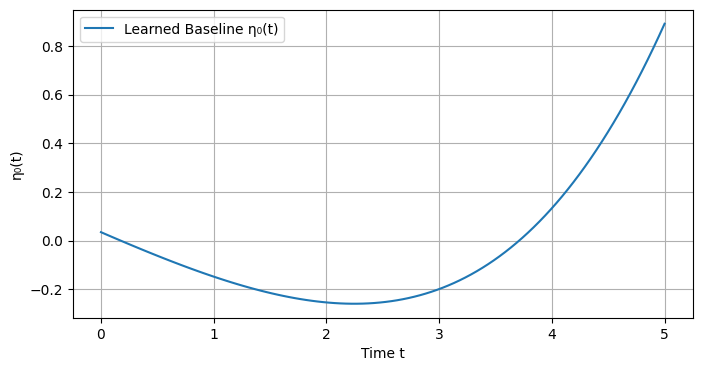

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

########################
# Helper Functions
########################

def compute_bspline_basis(t, knots, n_spline_terms):
    """
    Compute a B-spline basis matrix for time points t.
    For demonstration, this function returns a dummy basis
    using simple polynomials (0th, 1st, ..., (n_spline_terms-1)th powers)
    normalized to [0,1]. Replace with a proper B-spline evaluation if desired.

    Input:
      t: Tensor of shape [N]
      knots: tensor of knot locations (unused in this dummy version)
      n_spline_terms: number of basis functions to compute.
    Output:
      B: Tensor of shape [N, n_spline_terms]
    """
    # Normalize t to [0,1] (approx)
    t_min, t_max = t.min(), t.max()
    eps = 1e-8
    denom = (t_max - t_min) + eps
    t_norm = (t - t_min) / denom

    B_list = []
    # e.g. up to power n_spline_terms-1
    for power in range(n_spline_terms):
        B_list.append(t_norm**power)
    B = torch.stack(B_list, dim=1) # shape [N, n_spline_terms]
    return B

def evaluate_univariate_spline(x, spline_params, knots):
    """
    Evaluate a univariate piecewise-linear spline at input x.
    spline_params: Tensor of shape [num_knots] (the function's values at each knot).
    knots: Tensor of shape [num_knots] with increasing knot locations.
    We'll do a simple linear interpolation between adjacent knots.

    Input:
      x: shape [batch_size]
      spline_params: shape [num_knots]
      knots: shape [num_knots]

    Output:
      phi_x: shape [batch_size], each entry is the piecewise-linear interpolation.
    """
    # Bucketize x: returns indices in [0, num_knots]
    idx = torch.bucketize(x, knots, right=False)
    # clamp indices so that idx is >=1 and <= (num_knots - 1)
    idx = torch.clamp(idx, 1, knots.shape[0]-1)

    t_lower = knots[idx-1]
    t_upper = knots[idx]
    p_lower = spline_params[idx-1]
    p_upper = spline_params[idx]

    # Linear interpolation fraction
    denom = (t_upper - t_lower).clamp_min(1e-8)
    weight = (x - t_lower) / denom
    phi_x = p_lower + weight*(p_upper - p_lower)
    return phi_x

########################
# 1) BSplineBaseline for η₀(t)
########################

class BSplineBaseline(nn.Module):
    def __init__(self, n_spline_terms, knots):
        """
        n_spline_terms: number of basis functions
        knots: 1D tensor of knot locations over the time interval
        """
        super().__init__()
        self.n_spline_terms = n_spline_terms
        self.knots = knots  # We'll store it, though not used in our dummy approach
        # Learnable coefficients for the B-spline basis
        self.coefs = nn.Parameter(torch.zeros(n_spline_terms))
    
    def forward(self, t):
        """
        Evaluates η₀(t).
        In a real setting, you'd use a B-spline library, but here we do a dummy polynomial-like basis.
        t: shape [batch_size]
        Output: shape [batch_size] => the baseline value at each t
        """
        B = compute_bspline_basis(t, self.knots, self.n_spline_terms)  # [batch_size, n_spline_terms]
        eta_t = B.matmul(self.coefs)  # => shape [batch_size]
        return eta_t

########################
# 2) UnivariateKAN: Each edge function φ(x)
########################

class UnivariateKAN(nn.Module):
    """
    Implements a univariate transformation using a piecewise-linear spline.
    We fix the knot locations (uniformly spaced) in [knot_range[0], knot_range[1]].
    The 'spline_params' are the function values at each knot, which we learn.
    """
    def __init__(self, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.num_knots = num_knots
        # Create a buffer for the fixed knot locations
        self.register_buffer('knots', torch.linspace(knot_range[0], knot_range[1], steps=num_knots))
        # The learnable parameters: the function values at each knot
        self.spline_params = nn.Parameter(0.1 * torch.randn(num_knots))
    
    def forward(self, x):
        """
        x: shape [batch_size]
        returns: shape [batch_size], the univariate transform φ(x).
        """
        phi_x = evaluate_univariate_spline(x, self.spline_params, self.knots)
        return phi_x

########################
# 3) KANBlock: Sum of univariate edges from input to output dimension
########################

class KANBlock(nn.Module):
    """
    If we have input dimension in_dim and output dimension out_dim,
    we build out_dim * in_dim univariate functions φ_{u,v}.
    Then z_out[u] = sum_{v=1..in_dim} φ_{u,v}(z_in[v]).
    """
    def __init__(self, in_dim, out_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # We'll create (out_dim * in_dim) univariate edges
        self.edges = nn.ModuleList([
            UnivariateKAN(num_knots=num_knots, knot_range=knot_range)
            for _ in range(out_dim * in_dim)
        ])
    
    def forward(self, z_in):
        """
        z_in: shape [batch_size, in_dim]
        returns z_out: shape [batch_size, out_dim]
        """
        batch_size = z_in.shape[0]
        z_out = torch.zeros(batch_size, self.out_dim, device=z_in.device)
        idx = 0
        for u in range(self.out_dim):
            sum_u = 0
            for v in range(self.in_dim):
                phi_uv = self.edges[idx]
                sum_u = sum_u + phi_uv(z_in[:, v])
                idx += 1
            z_out[:, u] = sum_u
        return z_out

########################
# 4) KANModel: Stack KANBlocks to build f(x)
########################

class KANModel(nn.Module):
    """
    A two-layer KAN: (d_x -> hidden_dim) then (hidden_dim -> 1).
    This yields a single scalar output f(x).
    """
    def __init__(self, d_x, hidden_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.layer1 = KANBlock(d_x, hidden_dim, num_knots, knot_range)
        self.layer2 = KANBlock(hidden_dim, 1, num_knots, knot_range)
    
    def forward(self, x):
        """
        x: shape [batch_size, d_x]
        returns: shape [batch_size], the final scalar f(x)
        """
        z = self.layer1(x)         # shape [batch_size, hidden_dim]
        z = self.layer2(z)         # shape [batch_size, 1]
        return z.squeeze(-1)       # -> shape [batch_size]

########################
# 5) Full Inhomogeneous Poisson Process Model
########################

class InhomPoissonModel(nn.Module):
    """
    Combines:
      - A baseline function η₀(t) using B-spline-like expansions
      - A KAN for f(x)
    So the intensity is λ(t) = exp( η₀(t) + f(x) ).
    """
    def __init__(self, n_spline_terms, spline_knots, d_x, hidden_dim, num_knots=10, knot_range=(0.0, 1.0)):
        super().__init__()
        self.baseline = BSplineBaseline(n_spline_terms, spline_knots)
        self.fKAN = KANModel(d_x, hidden_dim, num_knots, knot_range)
    
    def intensity_at_time(self, t, x):
        """
        λ(t, x) = exp( η₀(t) + f(x) )
        t: shape [batch_size]
        x: shape [batch_size, d_x]
        returns: shape [batch_size]
        """
        baseline_val = self.baseline(t)   # [batch_size]
        f_val = self.fKAN(x)             # [batch_size]
        log_lambda = baseline_val + f_val
        return torch.exp(log_lambda)

########################
# 6) Log-Likelihood Computation & Training Loop
########################

def compute_loglik(model, batch_events, batch_censoring, n_integration_pts=10):
    """
    Compute the log-likelihood for a batch of subjects:
      - For subject i:
         log L_i = sum_{j=1..n_i} [ log λ(t_{ij}, x_{ij}) ]
                   - ∫ λ(t, x_i(t)) dt
      We'll assume x is constant in time, for simplicity.

    batch_events: list (length = num_subjects) of lists of events.
      Each event is a tuple (t_event, x_event).
        t_event: float
        x_event: Tensor [d_x]
    batch_censoring: list (length = num_subjects) of (c_i, x_i).
      c_i: censoring time
      x_i: Tensor [d_x], assumed constant over time for integration.
    """
    log_sum = 0.0
    device = next(model.parameters()).device
    for i, evts in enumerate(batch_events):
        # sum of log(lambda(t_{ij}, x_{ij}))
        if len(evts) > 0:
            tvals = torch.tensor([e[0] for e in evts], dtype=torch.float32, device=device)
            xvals = torch.stack([e[1] for e in evts], dim=0).to(device)  # shape [n_i, d_x]
            # Evaluate baseline + f(x)
            log_lam = torch.log(model.intensity_at_time(tvals, xvals))
            # Alternatively, we could do: baseline(tvals) + fKAN(xvals).
            # But to be consistent with possible modifications, let's do:
            log_sum_events = log_lam.sum()
        else:
            log_sum_events = 0.0

        # integral term: approximate ∫ exp{η₀(t) + f(x_i)} dt from 0..c_i
        cend = batch_censoring[i][0]
        x_const = batch_censoring[i][1].to(device)
        
        times_grid = torch.linspace(0.0, cend, steps=n_integration_pts, device=device)
        x_grid = x_const.unsqueeze(0).repeat(n_integration_pts, 1)
        lam_vals = model.intensity_at_time(times_grid, x_grid)  # shape [n_integration_pts]
        integral_approx = torch.trapz(lam_vals, times_grid)
        
        log_sum_i = log_sum_events - integral_approx
        log_sum += log_sum_i

    return log_sum

def generate_dummy_data(num_subjects=5, d_x=3):
    """
    Generates a dummy dataset:
      - For each subject, pick a censoring time c_i in [1,5].
      - A random number of events in [0,3].
      - Covariates in [0,1]^d_x (assume constant over time).
    Returns:
      batch_events, batch_censoring
    """
    batch_events = []
    batch_censoring = []
    for _ in range(num_subjects):
        c_i = torch.rand(1).item()*4 + 1.0
        n_events = torch.randint(0,4,(1,)).item()
        if n_events > 0:
            tvals = torch.sort(torch.rand(n_events)*c_i)[0]
            x_i = torch.rand(d_x)
            evs = [(float(t), x_i) for t in tvals]
        else:
            evs = []
            x_i = torch.rand(d_x)
        batch_events.append(evs)
        batch_censoring.append((c_i, x_i))
    return batch_events, batch_censoring

def main():
    # Baseline B-spline params
    n_spline_terms = 5
    # We'll define knots for t in [0,5], for example
    spline_knots = torch.linspace(0.0, 5.0, steps=n_spline_terms)
    
    # KAN structure:
    d_x = 3
    hidden_dim = 10
    num_knots = 10
    knot_range = (0.0, 1.0)  # assume x in [0,1]

    # Build model
    model = InhomPoissonModel(n_spline_terms, spline_knots,
                              d_x, hidden_dim, num_knots, knot_range)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Generate dummy data
    batch_events, batch_censoring = generate_dummy_data(num_subjects=20, d_x=d_x)

    # Training loop
    for iter in range(100):
        optimizer.zero_grad()
        loglik = compute_loglik(model, batch_events, batch_censoring, n_integration_pts=20)
        loss = -loglik  # negative log-likelihood
        loss.backward()
        optimizer.step()

        if iter % 10 == 0:
            print(f"Iteration {iter}: Loss = {loss.item():.4f}")

    # Visualize the learned baseline
    model.eval()
    t_grid = torch.linspace(0,5, steps=100)
    with torch.no_grad():
        eta_vals = model.baseline(t_grid)
    plt.figure(figsize=(8,4))
    plt.plot(t_grid.numpy(), eta_vals.numpy(), label='Learned Baseline η₀(t)')
    plt.xlabel('Time t')
    plt.ylabel('η₀(t)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
